### Spam, Ham 분류하기

#### 데이터 셋

- CSDM2010 SPAM corups 이용
    - 4,327 email, 라벨 포함(ham: 1,378, spam: 2,949)

#### 라이브러리 로딩 

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras

In [122]:
#sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("Paired")

In [123]:
import warnings
warnings.filterwarnings(action='ignore') 

#### 데이터 불러오기&탐색

**이메일 읽어오기**

In [124]:
path = './data/email/*'
file_list = glob.glob(path)
file_list_txt = [file for file in file_list if file.endswith('.txt')]
print('파일개수:', len(file_list_txt))

파일개수: 4327


In [125]:
emails = []
for file in file_list_txt:
#     print(file)
    with open(file, 'r') as f:
        lines = f.readlines()
        data = ' '.join(lines)
    emails.append(data)

In [126]:
def get_filename(path):
    name = os.path.basename(path)
    return name

In [127]:
df_email = pd.DataFrame(file_list_txt, columns=['file_path'])
df_email['file_name'] = df_email['file_path'].map(lambda path : get_filename(path))
df_email['email'] = emails
df_email.shape
df_email.head()

,file_path,file_name,email
0,./data/email/TRAIN_02429.eml.txt,TRAIN_02429.eml.txt,[SPAM] Dear hibody@csmining.org 79% 0FF on Pf...
1,./data/email/TRAIN_00509.eml.txt,TRAIN_00509.eml.txt,Re: Why are there no latest books written for ...
2,./data/email/TRAIN_04315.eml.txt,TRAIN_04315.eml.txt,We Dare You to Find a Better AnnuityFrom nobod...
3,./data/email/TRAIN_02983.eml.txt,TRAIN_02983.eml.txt,Re: FromFrom nobody Sun Sep 18 20:45:31 2016\n...
4,./data/email/TRAIN_03445.eml.txt,TRAIN_03445.eml.txt,[zzzzteana] Re: Archer-UK TV Alert> US listers...


**라벨 읽어오기**

In [128]:
df_label = pd.read_csv('./data/email/labels', sep=' ', header=None, names=['spam/ham', 'file_name'])
print(df_label.shape)
df_label.head()

(4327, 2)


,spam/ham,file_name
0,0,TRAIN_00000.eml.txt
1,0,TRAIN_00001.eml.txt
2,1,TRAIN_00002.eml.txt
3,0,TRAIN_00003.eml.txt
4,0,TRAIN_00004.eml.txt


**데이터 합치기**

In [129]:
df_all = pd.merge(df_email, df_label, on='file_name')
print(df_all.shape)
df_all.head(10)

(4327, 4)


,file_path,file_name,email,spam/ham
0,./data/email/TRAIN_02429.eml.txt,TRAIN_02429.eml.txt,[SPAM] Dear hibody@csmining.org 79% 0FF on Pf...,0
1,./data/email/TRAIN_00509.eml.txt,TRAIN_00509.eml.txt,Re: Why are there no latest books written for ...,1
2,./data/email/TRAIN_04315.eml.txt,TRAIN_04315.eml.txt,We Dare You to Find a Better AnnuityFrom nobod...,0
3,./data/email/TRAIN_02983.eml.txt,TRAIN_02983.eml.txt,Re: FromFrom nobody Sun Sep 18 20:45:31 2016\n...,1
4,./data/email/TRAIN_03445.eml.txt,TRAIN_03445.eml.txt,[zzzzteana] Re: Archer-UK TV Alert> US listers...,1
5,./data/email/TRAIN_02071.eml.txt,TRAIN_02071.eml.txt,Police pay damages to journalistURL: http://ww...,1
6,./data/email/TRAIN_00331.eml.txt,TRAIN_00331.eml.txt,Re: Increasing number of conflictsFrom nobody ...,1
7,./data/email/TRAIN_00191.eml.txt,TRAIN_00191.eml.txt,Re: [ILUG] removing liloQuoting jac1 (jac1@stu...,1
8,./data/email/TRAIN_02208.eml.txt,TRAIN_02208.eml.txt,Re: KDE 4.4.3 in unstableFrom nobody Sun Sep 1...,1
9,./data/email/TRAIN_03709.eml.txt,TRAIN_03709.eml.txt,blogged itemBlogStart: \n \n **Dublin**: somet...,1


In [130]:
df = df_all[['email', 'spam/ham']]
df

,email,spam/ham
0,[SPAM] Dear hibody@csmining.org 79% 0FF on Pf...,0
1,Re: Why are there no latest books written for ...,1
2,We Dare You to Find a Better AnnuityFrom nobod...,0
3,Re: FromFrom nobody Sun Sep 18 20:45:31 2016\n...,1
4,[zzzzteana] Re: Archer-UK TV Alert> US listers...,1
...,...,...
4322,Your Credit-Scores have been UpdatedFrom nobod...,0
4323,RE: Re[2]: Goodbye Global Warming> From: bitbi...,1
4324,An Information\n \n \n \n \n An I n f o r m ...,0
4325,sharing NFS folder in multiples serversHi agai...,1


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4327 entries, 0 to 4326
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   email     4327 non-null   object
 1   spam/ham  4327 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 101.4+ KB


**결측치, 중복값제거**

In [132]:
df.isnull().values.any()

False

In [133]:
df['email'].duplicated().value_counts()

False    4110
True      217
Name: email, dtype: int64

In [134]:
df.drop_duplicates(subset=['email'], inplace=True)
print('중복제거 후 이메일 수: ', len(df))

중복제거 후 이메일 수:  4110


In [135]:
df['spam/ham'].value_counts()


1    2770
0    1340
Name: spam/ham, dtype: int64

<AxesSubplot:xlabel='spam/ham', ylabel='count'>

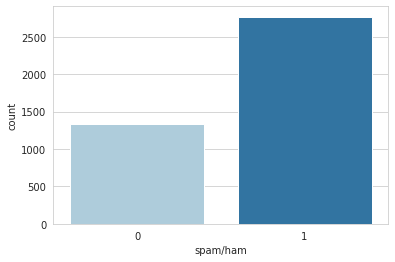

In [136]:
sns.countplot(x='spam/ham', data=df)

#### 데이터 전처리 

In [137]:
X_data = df['email']
y_data = df['spam/ham']

**토큰화, 인코딩**

In [138]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [139]:
# print(sequences[:10])

[[163, 994, 376, 240, 21, 3396, 5512, 15, 2282, 176, 102, 78, 2, 318, 22, 5, 151, 255, 49, 28, 201, 73, 91, 199, 28, 525, 476, 28, 67, 103, 488, 898, 295, 34651, 434, 38, 301, 436], [57, 266, 20, 65, 53, 643, 1499, 909, 8, 26, 467, 23, 231, 180, 196, 136, 28, 208, 462, 261, 93, 139, 98, 234, 250, 384, 451, 31, 693, 10, 530, 23202, 9, 141, 11906, 2220, 8, 1, 64, 727, 2, 954, 1, 602, 4, 26, 675, 22, 820, 378, 75, 71, 410, 1351, 509, 6374, 95, 10844, 23203, 75, 340, 410, 34652, 924, 9, 1152, 2, 540, 5, 727, 67, 26, 9, 354, 12, 1, 302, 727, 909, 35, 146, 215, 6, 3397, 29, 1351, 509, 6374, 11, 34, 4586, 17, 1351, 509, 6374, 73, 34653, 5912, 3801, 15382, 34654, 34655, 31, 289, 23204, 34656, 34657, 3801, 94, 31, 170, 3397, 5513, 4, 597, 123, 1153, 6, 87, 191, 131, 6139, 53, 56, 682, 2, 617, 5, 727, 6140, 8, 26, 597, 25, 5513, 266, 143, 1126, 339, 3802, 1499, 7, 24, 5, 146, 2, 125, 578, 203, 8, 5, 1109, 4, 429, 326, 5514, 15, 9, 141, 213, 425, 15, 5, 64, 1536, 4587, 2, 18, 1153, 16, 25, 4355, 

In [140]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: ', vocab_size)

단어 집합의 크기:  82846


In [141]:
# print(word_to_index)

{'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5, 'in': 6, 'is': 7, 'for': 8, 'i': 9, 'you': 10, 'http': 11, 'that': 12, 'it': 13, 'this': 14, 'on': 15, 'with': 16, 'com': 17, 'be': 18, 'your': 19, 'are': 20, 'org': 21, 'as': 22, 'from': 23, 'not': 24, 'or': 25, 'debian': 26, 'have': 27, '20': 28, 'by': 29, 'at': 30, '1': 31, 'lists': 32, 'if': 33, 'www': 34, 'was': 35, 'but': 36, 'an': 37, 'all': 38, 'will': 39, 'can': 40, '2': 41, 'my': 42, 'email': 43, 'list': 44, 'net': 45, '3': 46, '0': 47, 'do': 48, 'unsubscribe': 49, 'we': 50, 'has': 51, 'more': 52, 'no': 53, 'our': 54, 'which': 55, 'one': 56, 're': 57, 'so': 58, 'they': 59, 'get': 60, 'wrote': 61, 'use': 62, 'out': 63, 'new': 64, 'there': 65, 'what': 66, 'about': 67, 'just': 68, 'when': 69, 'any': 70, '4': 71, 'some': 72, 'e': 73, '09': 74, '2010': 75, 'now': 76, 'only': 77, 'here': 78, 'time': 79, '3e': 80, 'up': 81, 'like': 82, '\xa0': 83, 'other': 84, 'linux': 85, '2002': 86, '5': 87, 'would': 88, '3d': 89, 'me': 90, 'mail': 91

In [142]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key
print('최빈 단어: ', index_to_word[1])

최빈 단어:  the


In [143]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print('단어 집합(vocabulary)에서 희귀 단어의 비율: {}'.format((rare_cnt / total_cnt)*100))
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 48195
단어 집합(vocabulary)에서 희귀 단어의 비율: 58.174904942965775
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7088911035095755


email 최대 길이:  24342
email 최대 길이:  316.1666666666667


<AxesSubplot:>

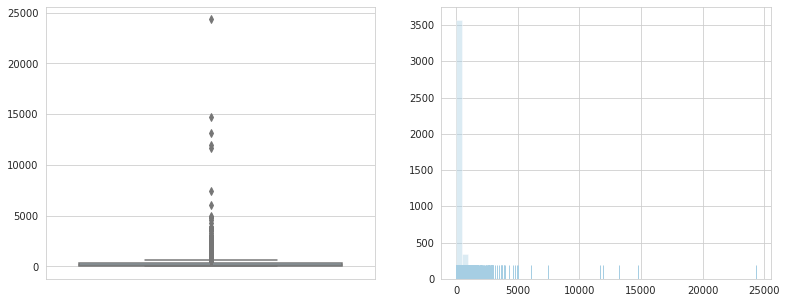

In [144]:
X_data = sequences
len_contents = [len(s) for s in X_data]

max_len = np.max(len_contents)
mean_len = np.mean(len_contents)

print('email 최대 길이: ', max_len)
print('email 최대 길이: ', mean_len)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(y=len_contents, data=df['email'])
plt.subplot(1,2,2)
sns.distplot(len_contents, kde=False, rug=True)

#### LSTM으로 이메일 분류하기

**학습,테스트데이터 분류**

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2, stratify=y_data,
                                                    shuffle=True, random_state=39)


In [146]:
print('Train Dataset: ', len(X_train))
print('Test Dataset: ', len(X_test))
print('Category: ', max(y_train)+1)

Train Dataset:  3288
Test Dataset:  822
Category:  2


**가장 긴 메일 길이로 패딩**

In [147]:
X_train = pad_sequences(X_train, maxlen=max_len, dtype='int32', 
                        padding='pre', truncating='pre', value=0.)
X_test = pad_sequences(X_test, maxlen=max_len, dtype='int32', 
                        padding='pre', truncating='pre', value=0.)
print('이메일 길이 변환: {} {}'.format(X_train.shape, X_test.shape))

이메일 길이 변환: (3288, 24342) (822, 24342)


**모델만들기**

In [148]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 64),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

In [149]:
model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])
 

In [150]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5302144   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,376,513
Trainable params: 5,376,513
Non-trainable params: 0
_________________________________________________________________


In [156]:
early_stopping = keras.callbacks.EarlyStopping(patience=3)

In [157]:
history = model.fit(X_train, y_train, 
                    epochs=10, validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/10
83/83 [==============================] - 134s 2s/step - loss: 0.3967 - accuracy: 0.8886 - val_loss: 0.2569 - val_accuracy: 0.8936
Epoch 2/10
83/83 [==============================] - 136s 2s/step - loss: 0.1671 - accuracy: 0.9510 - val_loss: 0.1425 - val_accuracy: 0.9574
Epoch 3/10
83/83 [==============================] - 135s 2s/step - loss: 0.0794 - accuracy: 0.9825 - val_loss: 0.1530 - val_accuracy: 0.9331
Epoch 4/10
83/83 [==============================] - 134s 2s/step - loss: 0.0597 - accuracy: 0.9837 - val_loss: 0.0996 - val_accuracy: 0.9681
Epoch 5/10
83/83 [==============================] - 135s 2s/step - loss: 0.0301 - accuracy: 0.9943 - val_loss: 0.1011 - val_accuracy: 0.9711
Epoch 6/10
83/83 [==============================] - 137s 2s/step - loss: 0.0195 - accuracy: 0.9954 - val_loss: 0.0683 - val_accuracy: 0.9787
Epoch 7/10
83/83 [==============================] - 136s 2s/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0852 - val_accuracy: 0.9666
Epoch 8/10
83

**모델평가**

In [159]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

26/26 [==============================] - 15s 563ms/step - loss: 0.0666 - accuracy: 0.9696
Test Loss: 0.06656783074140549
Test Accuracy: 0.9695863723754883


In [162]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

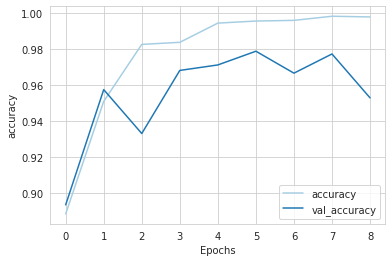

In [163]:
plot_graphs(history, 'accuracy')

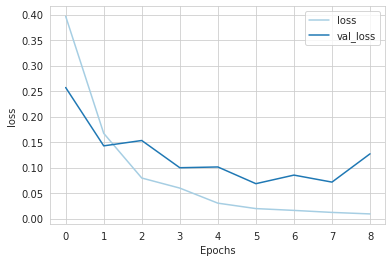

In [164]:
plot_graphs(history, 'loss')